<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Accumulate_ResNet50_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Tue May 26 16:37:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Run:AI Gradient Accumulation library
https://github.com/run-ai/runai/tree/master/runai/ga

In [2]:
!pip install runai

# Import Libraries

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.legacy import interfaces
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import runai.ga.keras

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 16
STEPS = 16
LR = 1e-3
EPOCHS = 100

# Data Preparation

In [6]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 64.95 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


In [0]:
metadata_path = '/content/ham10000-with-one-image-folder/HAM10000_metadata.csv'
img_path = '/content/ham10000-with-one-image-folder/HAM1000_images'

In [0]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
data = pd.read_csv(metadata_path)

In [0]:
num_examples = data.values.shape[0]

In [0]:
inputs = np.empty(shape=(num_examples, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

## Resize to 224*224

In [0]:
for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    all_img_path = os.path.join(img_path, img_id) + '.jpg' 
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    else:
        raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

## Split Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=555)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=555)

In [14]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


## Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

In [0]:
datagen.fit(x_train)

# Adam Accumulate

In [17]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [26-05-2020 16:42:28.208] [137] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Build Model
DenseNet121 + fine tuning

In [0]:
def build_model():
  base_model = ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(average_pooling_layer)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(fc_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  model.compile(optimizer=ga_optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [19]:
model = build_model()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='acc_densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [22]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=[early_stop, model_checkpoint, reduce_lr_rate])


Epoch 1/100
395/395 [==============================] - 81s 205ms/step - loss: 1.7333 - accuracy: 0.4692 - val_loss: 5.5310 - val_accuracy: 0.1172
Epoch 2/100
395/395 [==============================] - 67s 170ms/step - loss: 1.3652 - accuracy: 0.6318 - val_loss: 3.0259 - val_accuracy: 0.3025
Epoch 3/100
395/395 [==============================] - 67s 169ms/step - loss: 1.2252 - accuracy: 0.6749 - val_loss: 1.7143 - val_accuracy: 0.7463
Epoch 4/100
395/395 [==============================] - 67s 169ms/step - loss: 1.0739 - accuracy: 0.7160 - val_loss: 1.5555 - val_accuracy: 0.7733
Epoch 5/100
395/395 [==============================] - 67s 169ms/step - loss: 1.0236 - accuracy: 0.7220 - val_loss: 1.7022 - val_accuracy: 0.7526
Epoch 6/100
395/395 [==============================] - 66s 168ms/step - loss: 0.9244 - accuracy: 0.7332 - val_loss: 1.5609 - val_accuracy: 0.7763
Epoch 7/100
395/395 [==============================] - 66s 168ms/step - loss: 0.8792 - accuracy: 0.7418 - val_loss: 1.4717 

# Graph

## Accuracy

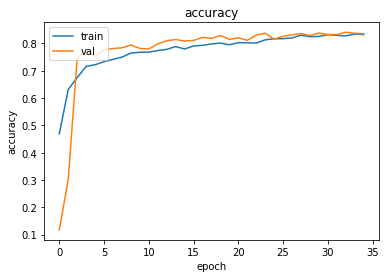

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

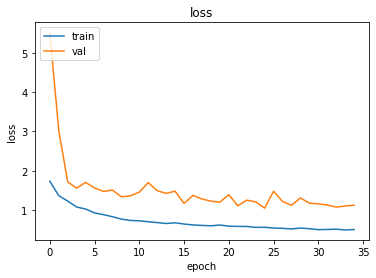

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = load_model('/content/acc_densenet121_model.h5', compile=False)

In [27]:
y_pred = np.argmax(test_model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.6078384814713166


## Classification Report

In [28]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.61      0.52      0.56        33
         bcc       0.55      0.73      0.62        41
         bkl       0.61      0.70      0.65        99
          df       0.33      0.08      0.12        13
         mel       0.54      0.57      0.55       118
          nv       0.92      0.90      0.91       681
        vasc       0.87      0.76      0.81        17

    accuracy                           0.81      1002
   macro avg       0.63      0.61      0.61      1002
weighted avg       0.81      0.81      0.81      1002



## Confusion Matrix

Confusion matrix, without normalization
[[ 17   7   5   0   4   0   0]
 [  3  30   3   0   0   4   1]
 [  1   4  69   0  12  13   0]
 [  1   5   2   1   1   3   0]
 [  6   4  10   1  67  29   1]
 [  0   4  23   1  39 614   0]
 [  0   1   1   0   1   1  13]]


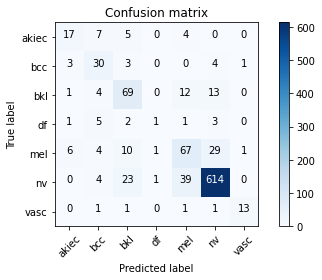

In [29]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

## Sensitivity & Specificity

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [31]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.7083
specificity: 0.9091


# Grad-CAM

In [0]:
last_conv2d = 'res5c_branch2c'

## AKIEC

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.996
	bkl            	(2)	with probability 0.002
	akiec          	(0)	with probability 0.001
	nv             	(5)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


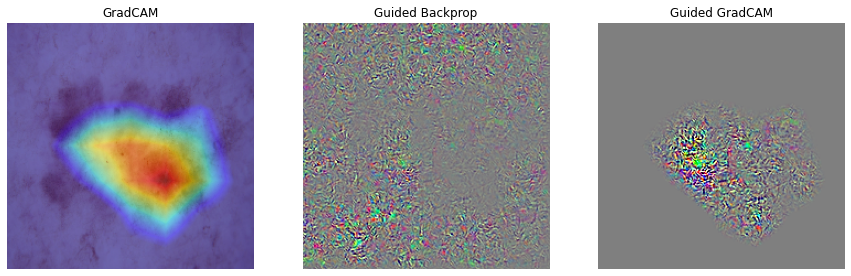

In [37]:
radcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

## BCC

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.706
	bkl            	(2)	with probability 0.201
	nv             	(5)	with probability 0.059
	bcc            	(1)	with probability 0.019
	akiec          	(0)	with probability 0.007
Explanation for 'mel'


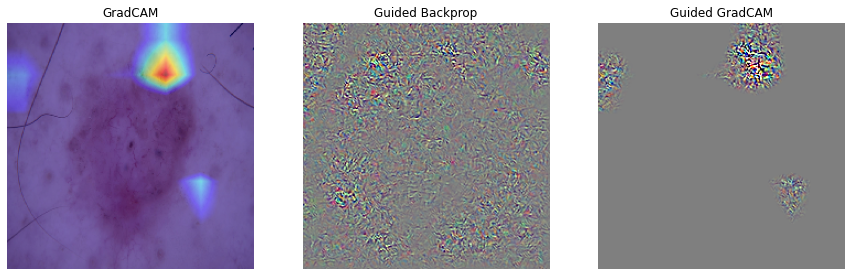

In [39]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.755
	nv             	(5)	with probability 0.128
	bkl            	(2)	with probability 0.111
	bcc            	(1)	with probability 0.003
	vasc           	(6)	with probability 0.001
Explanation for 'mel'


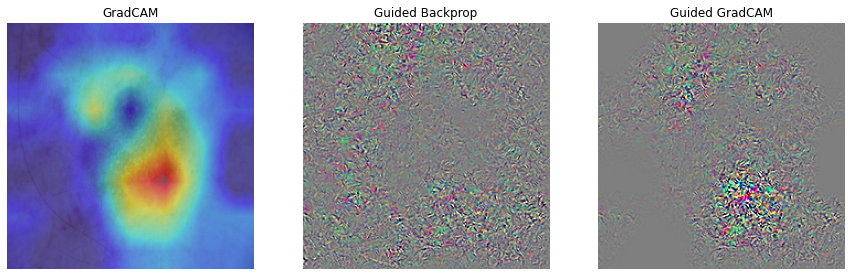

In [41]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.854
	nv             	(5)	with probability 0.138
	bkl            	(2)	with probability 0.006
	vasc           	(6)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


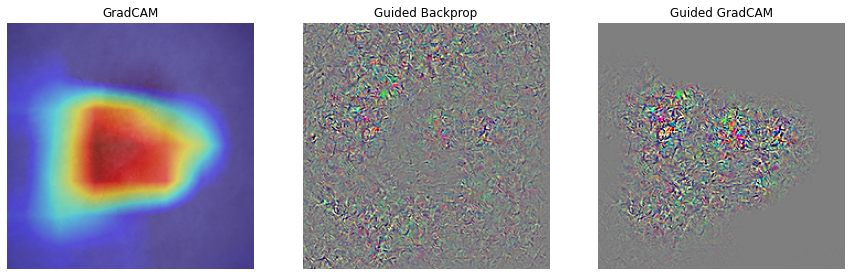

In [43]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.866
	nv             	(5)	with probability 0.129
	bkl            	(2)	with probability 0.003
	vasc           	(6)	with probability 0.001
	akiec          	(0)	with probability 0.001
Explanation for 'mel'


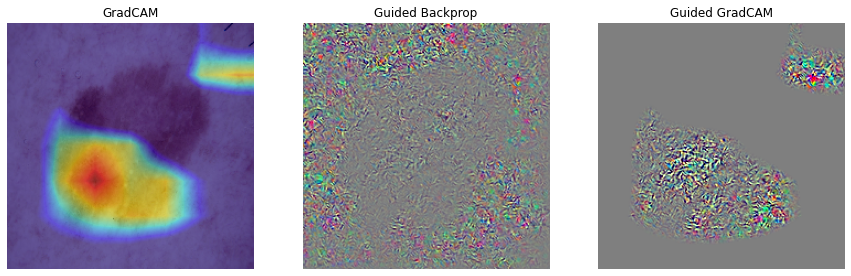

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	vasc           	(6)	with probability 0.572
	nv             	(5)	with probability 0.398
	mel            	(4)	with probability 0.029
	bcc            	(1)	with probability 0.001
	bkl            	(2)	with probability 0.000
Explanation for 'vasc'


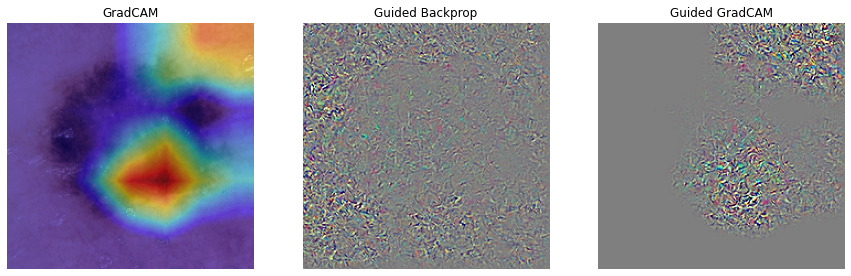

In [47]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 0.852
	vasc           	(6)	with probability 0.145
	mel            	(4)	with probability 0.002
	bcc            	(1)	with probability 0.001
	df             	(3)	with probability 0.000
Explanation for 'nv'


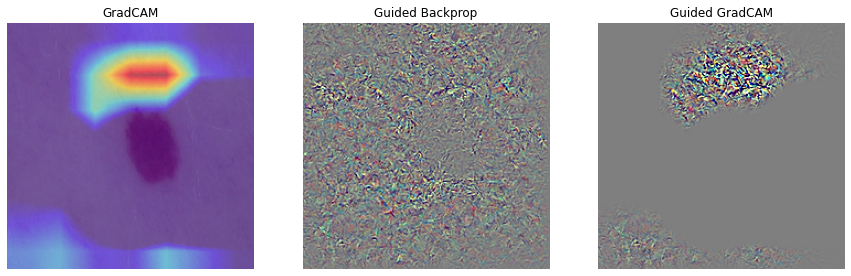

In [49]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# Download Model

In [0]:
from google.colab import files

In [51]:
files.download('/content/acc_densenet121_model.h5')

MessageError: ignored